# Time Series: ARIMA Models 
Time series is a complex topic, we are only touching the surface of what can be done! Here we are covering univariate time series models. 

**Recap:** 

- What is a time series? X is time, y is anything dependent on time. 
- What does it look like? 
- What are we trying to predict? 
- What are characteristics to look for in your time series?
    - trend, seasonality, noise

## Time Series Workflow

  1. Load the data
  2. Clean the data - make a time series
  3. Test train split!
  4. Visualize your time series
  5. Plot ACF and PACF
  6. Check for stationarity!
  8. Choose p, q terms and type of model to use 
  9. Build your model
  10. Evaluate your model

## 1. Load the data!

We're going to work with unemployment data. 

In [110]:
#import libraries
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
%matplotlib inline

In [111]:
#load the data
data = pd.read_csv('data/unemployment.csv')
data.head()

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
0,1948Q1,3.733%
1,1948Q2,3.667%
2,1948Q3,3.767%
3,1948Q4,3.833%
4,1949Q1,4.667%


In [112]:
#let's check the object types
data.info()

#we see that both columns have objects as the type. 
#we'll need to give it a date index and a float to begin our analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 2 columns):
Quarter                                                                    175 non-null object
Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993    174 non-null object
dtypes: object(2)
memory usage: 2.8+ KB


## 2. Clean the data
- Make into date time object and float
- Any nulls?
- Do we want to resample?

In [113]:
#rename columns
data.columns = ['year_quarter', 'unemployment_rate']

#make unemployment_rate into float and remove % sign
data['unemployment_rate'] = data['unemployment_rate'].map(lambda x: float(str(x).replace('%','')))

#drop any nulls
data.dropna(inplace=True)

data.head()

,year_quarter,unemployment_rate
0,1948Q1,3.733
1,1948Q2,3.667
2,1948Q3,3.767
3,1948Q4,3.833
4,1949Q1,4.667


In [114]:
#check your object type now
data.dtypes

year_quarter          object
unemployment_rate    float64
dtype: object

In [115]:
#let's give it a date index so we can plot

#create a new column called date and create an index 
data['date'] = pd.to_datetime(data.year_quarter).dt.to_period('Q')
data.set_index('date', inplace=True)
data.head()

,year_quarter,unemployment_rate
date,,
1948Q1,1948Q1,3.733
1948Q2,1948Q2,3.667
1948Q3,1948Q3,3.767
1948Q4,1948Q4,3.833
1949Q1,1949Q1,4.667


In [116]:
#now let's check the dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 174 entries, 1948Q1 to 1991Q2
Freq: Q-DEC
Data columns (total 2 columns):
year_quarter         174 non-null object
unemployment_rate    174 non-null float64
dtypes: float64(1), object(1)
memory usage: 4.1+ KB


## 3. Visualize the time series 

What are factors that might influence your data
- deflation?
- is there a trend?
- is the trend additive or multiplicative?
- is there seasonality?

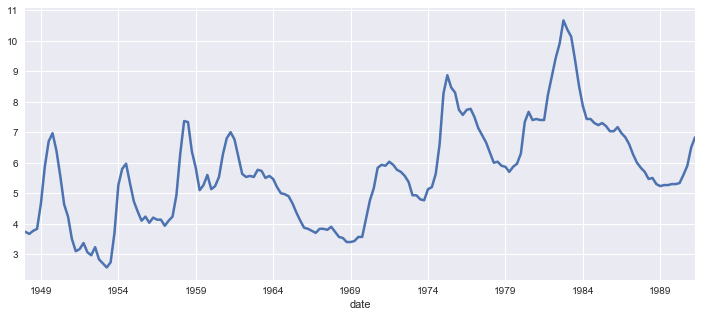

In [117]:
#plot the time series
data['unemployment_rate'].plot(lw=2.5, figsize=(12,5))

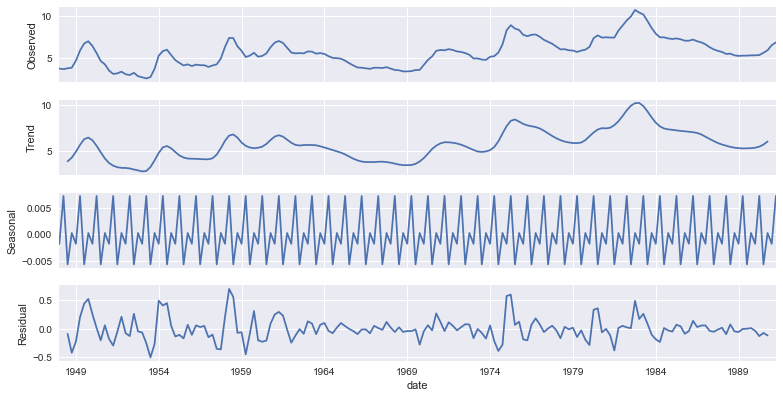

In [118]:
#use seasonal decompose to look at trend, seasonality and residuals (noise) in the data

#import the library
from statsmodels.tsa.seasonal import seasonal_decompose

#create a dataframe with unemployment rate as the data, columns called rate, and timestamped index
data_ts = pd.DataFrame(data[['unemployment_rate']].values, columns=['rate'], index=data.index.to_timestamp())

#decompose your time series
result = seasonal_decompose(data_ts.rate)

#plot the seasonal decomposition
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(12, 6)

**What do we see?**
- a slight trend, not super strong seasonality

## 4. Train test split!

At this point you should do a test train split but because your data is time dependent, you can't just take a random sampling - you have to split the data in sequential order. 

In [128]:
#split 75% train, 25% test
train_index = round(data.shape[0]*.75)

In [129]:
#create train and test set
train = data[:train_index]
test = data[train_index:]

In [167]:
train

,year_quarter,unemployment_rate,unemp_diff
date,,,
1948Q1,1948Q1,3.733,NaN
1948Q2,1948Q2,3.667,-0.066
1948Q3,1948Q3,3.767,0.100
1948Q4,1948Q4,3.833,0.066
1949Q1,1949Q1,4.667,0.834
1949Q2,1949Q2,5.867,1.200
1949Q3,1949Q3,6.700,0.833
1949Q4,1949Q4,6.967,0.267
1950Q1,1950Q1,6.400,-0.567


## 5. Check for Stationarity!

If a time series is stationary, the mean, variance, and autocorrelation (covered in the next section) are constant over time. Forcasting methods typically assume that the timeseries you are forcasting on are stationary, or at least approximately stationary so you must get your time series to be stationary! 

**Check for understanding**
- Would most real world data be stationary or not stationary?


### How would I know if my time series is stationary?

- Easy! You can just look at it!

![.](https://www.otexts.org/sites/default/files/resize/fpp/images/stationary-570x533.png)

*source: https://www.otexts.org/fpp/8/1*


Or if you want the more exacting way you can use the [Dickey-fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)

## So my time series is not stationary, what do I do?

The most common way to make a timeseries stationary is to perform **"differencing"**. This procedure converts a timeseries into the difference between values:

<a id="-delta-yt--yt---yt--"></a>
### $$ \Delta y_t = y_t - y_{t-1} $$

This removes trends in the timeseries and ensures that the mean across time is zero. In most cases there will only be a need for a single differencing, although sometimes a second difference (or even more) will be taken to remove trends.


In [123]:
#Difference the unemployment rate
data['unemp_diff'] = data.unemployment_rate.diff()
data.head()

,year_quarter,unemployment_rate,unemp_diff
date,,,
1948Q1,1948Q1,3.733,NaN
1948Q2,1948Q2,3.667,-0.066
1948Q3,1948Q3,3.767,0.100
1948Q4,1948Q4,3.833,0.066
1949Q1,1949Q1,4.667,0.834


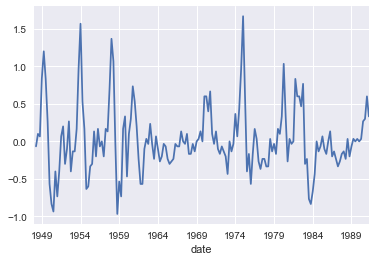

In [133]:
#let's plot it to make sure it worked
data.unemp_diff.plot()

#time series looks now centered on 0

## 6. Plot the autocorrelation (ACF) and partial autocorrelation (PACF)

Autocorrelation is a measure of *how correlated a variable is with itself*.

- In *non-time-series* analyses we often **must** assume observations $Y_i$ are **independent**
- In *time-series* analysis we often **must** assume observations are **dependent**

*Autocorrelation* allows us to check for this type of *sequential dependence*


The *correlation* between time series is

$$ Corr(Y_t, Z_t) = \frac{Cov(Y_t,Z_t)}{\sqrt{Var(Y_t)Var(Z_t)}} $$


The *autocorrelation of a series* is the correlation between a time series and a **lagged version** of itself.

$$ Corr(Y_t, Y_{t+k}) = \frac{Cov(Y_t,Y_{t+k})}{\sqrt{Var(Y_t)Var(Y_{t+k})}} $$

**Partial Autocorrelation**

Another important chart for diagnosing your time series is the partial autocorrelation chart (PACF). This is similar to autocorrelation, but, instead of being just the correlation at increasing lags, it is the correlation at a given lag, *controlling for the effect of previous lags*.

Another way to put it: *"A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed."*

source: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

In [140]:
#import the libraries
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

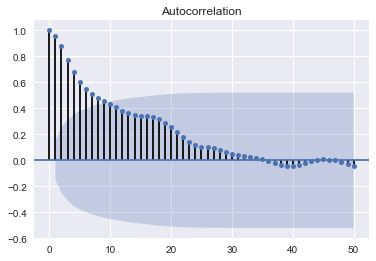

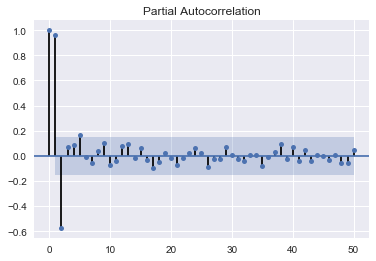

In [155]:
#let's plot the non stationary data

plot_acf(data.unemployment_rate, lags = 50);
plot_pacf(data.unemployment_rate, lags = 50);

**Check:** 

1. What does autocorrelation tell you?
    - Autocorrelation allows you to see seasonality in terms of what time period ago is most correlated with the present time series
    - Points outside shaded blue region tells you which lag has the most significant correlation

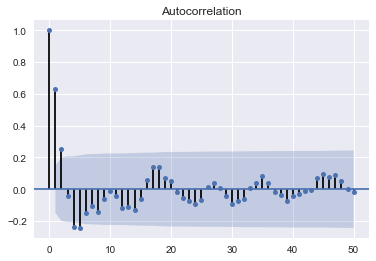

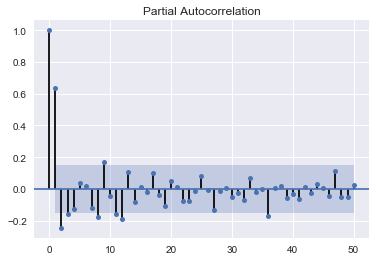

In [153]:
#let's plot the differenced data

udiff = data.unemp_diff
udiff.dropna(inplace =True)

plot_acf(data.unemp_diff, lags = 50);
plot_pacf(data.unemp_diff, lags = 50);

### Independent Practice: Try steps 1-6 of the time series workflow with the bus dataset

1. Load the data
2. Clean the data - make a time series
3. Test train split!
4. Visualize your time series
5. Plot ACF and PACF
6. Check for stationarity!

The data is already loaded for you

In [159]:
#load your data
bus = pd.read_csv('data/bus.csv')

In [ ]:
#clean your data - make it a datetime object

In [ ]:
#test train split!

In [ ]:
# visualize your time series

In [ ]:
#plot acf/pacf

In [160]:
#check fo stationarity

## Time Series Forecasting

There are many ways you can do a time series forecast, we are just covering two of them. If you want to learn more, look at the bonus lesson in this folder and check out this site https://people.duke.edu/~rnau/411home.htm

### Autoregressive (AR) models

---

Autoregressive (AR) models use data from previous time-points to predict the next time-point. These are essentially regression models where the predictors are previous timepoints of the outcome.

Typically, AR models are denoted `AR(p)`, where _p_ indicates the number of previous time points to incorporate. `AR(1)` is the most common.

In an autoregressive model we learn regression coefficients on the features that are the previous _p_ values.

### $$y_i = \beta_0 + \beta_1  y_{i-1} + \beta_2  y_{i-2}\ +\ ...\ +\ \beta_p  y_{i-p}\ +\ \epsilon \\
y_i =\sum_{j=1}^p \beta_j y_{i-j} + \epsilon$$

We can build autoregressive models using the `ARMA` class from statsmodels. 

> Alternatively, there is a newer python package called pyflux that also looks promising for time series modeling.  We won't cover pyflux in class.

### Moving Average (MA) models

**Moving average models** take previous _error terms_ as inputs. They predict the next value based on deviations from previous predictions. This can be useful for modeling a sudden occurrence - like something going out of stock affecting sales or a sudden rise in popularity.

As in autoregressive models, we have an order term, _q_, and we refer to our model as `MA(q)`.  This moving average model is dependent on the last _q_ errors. If we have a time series of sales per week, $y_i$, we can regress each $y_i$ on the last _q_ error terms.

### $$y_t = \epsilon_t + \beta_{1} \epsilon_{t-1} + ... \beta_{n} \epsilon_{t-n} \\
y_t = \sum_{i=1}^n \beta_i \epsilon_{t-i} + \epsilon_t$$

Sometimes the mean of the timeseries is included in the equation:

### $$ y_t = \mu + \sum_{i=1}^n \beta_i \epsilon_{t-i} + \epsilon_t $$

Moving average models are not as trivial to fit as autoregressive models because the error terms are unobserved. [There are a variety of different ways you can estimate the parameters, some of which are covered in this paper.](https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf)

In the simpler fitting procedures, a model is iteratively fit, errors are computed, then refit, over and over again until the parameters on the errors converge.

MA includes the mean of the time series. The behavior of the model is therefore characterized by random jumps around the mean value.



### How do I know whether to use an AR or MA model and how to choose the right `p` & `q` parameters?
---

In general it is never a bad idea to choose your parameters based on hold-out testing. That is to say, checking the performance of your model on future timepoints based on different choices of `p` and `q` for an ARIMA model.

However, you can get a sense for what parameters will work best based on the autocorrelation and partial autocorrelation charts.

In general though, below are some basic guidelines. Remember that these rules apply to the ACF and PACF plots of differenced timeseries rather than the original timeseries (the exception being if your timeseries is stationary and does not require differencing):

1. If the PACF has a sharp cutoff and the lag-1 ACF value is positive then choose an AR(x) term where x is the lag in the PACF after the cutoff.
2. If the ACF has a sharp cutoff and the lag-1 ACF value is negative, choose an MA(x) term where x is the lag in the ACF after the cutoff.
3. If both the ACF and PACF show a gradual decay, and ARMA model is likely appropriate as opposed to the AR or MA alone.

Context 1 above corresponds to timeseries that are "underdifferenced" as indicated by a positive autocorrelation at lat 1. Likewise, context 2 is "overdifferenced" as indicated by the negative autocorrelation.

In general, you should try to choose an AR or MA model alone as opposed to an ARMA model. The AR and MA terms can work against each other in the model and create an overly-complex representation.

In [175]:
#ARMA models combines AR and MA models into one class

from statsmodels.tsa.arima_model import ARMA

train_diff = train.unemp_diff.dropna()
test_diff = test.unemp_diff.dropna()

#let's try out a few models and compare their AIC score

**Pro-tip**: AIC in the results above refer to the [Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion).  AIC measures the "quality" of your model: lower values of AIC suggest better models!

See also: the #1 answer [here](https://stats.stackexchange.com/questions/187373/interpretation-of-aic-value):

> ... Lower value of AIC suggests "better" model, but it is a relative measure of model fit. It is used for model selection, i.e. it lets you to compare different models estimated on the same dataset.


In [177]:
ar1 = ARMA(train_diff.values, (1,0)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  129
Model:                     ARMA(1, 0)   Log Likelihood                 -50.500
Method:                       css-mle   S.D. of innovations              0.357
Date:                Mon, 07 May 2018   AIC                            107.000
Time:                        23:28:51   BIC                            115.579
Sample:                             0   HQIC                           110.486
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0399      0.085      0.468      0.640      -0.127       0.207
ar.L1.y        0.6353      0.069      9.186      0.000       0.500       0.771
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5740           +0.0000j            1.5740            0.0000
-----------------------------------------------------------------------------
"""

In [178]:
#let's try moving average
ma1 = ARMA(train_diff.values, (0,1)).fit()
ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  129
Model:                     ARMA(0, 1)   Log Likelihood                 -51.932
Method:                       css-mle   S.D. of innovations              0.361
Date:                Mon, 07 May 2018   AIC                            109.864
Time:                        23:29:02   BIC                            118.443
Sample:                             0   HQIC                           113.350
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0307      0.053      0.583      0.561      -0.072       0.134
ma.L1.y        0.6611      0.070      9.431      0.000       0.524       0.798
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.5127           +0.0000j            1.5127            0.5000
-----------------------------------------------------------------------------
"""

In [179]:
#let's try a combo
ar1ma1 = ARMA(train_diff.values, (1,1)).fit()
ar1ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  129
Model:                     ARMA(1, 1)   Log Likelihood                 -46.400
Method:                       css-mle   S.D. of innovations              0.346
Date:                Mon, 07 May 2018   AIC                            100.800
Time:                        23:29:07   BIC                            112.239
Sample:                             0   HQIC                           105.448
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0365      0.074      0.491      0.624      -0.109       0.182
ar.L1.y        0.4590      0.112      4.116      0.000       0.240       0.678
ma.L1.y        0.3305      0.113      2.920      0.004       0.109       0.552
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1785           +0.0000j            2.1785            0.0000
MA.1           -3.0260           +0.0000j            3.0260            0.5000
-----------------------------------------------------------------------------
"""

Looks like the combo has the lowest AIC score

In [186]:
#get r2 score!
from sklearn.metrics import r2_score
r2 = r2_score(train_diff, ar1ma1.fittedvalues)
print(r2)

0.432367031155


In [206]:
#let's look at how this model does on the test set

#make predictions
predictions = ar1ma1.predict(start=train_index, end = train_index+test.shape[0]-2)

In [207]:
predictions.shape
test.shape

(44, 3)

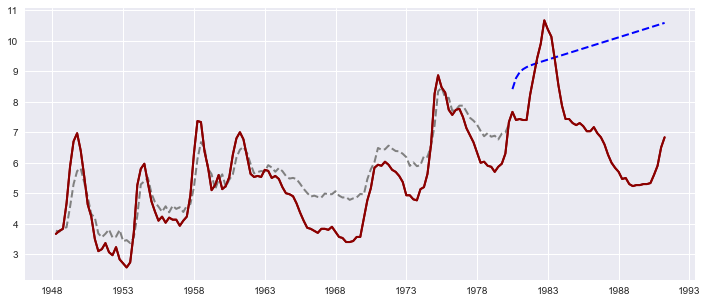

In [208]:
#reconstruct the full prediction!

date_ticks = data.index.to_timestamp()

full_pred_train = train.unemployment_rate.values[0]+np.cumsum(ar1ma1.fittedvalues)
full_pred_test = test.unemployment_rate.values[0]+np.cumsum(predictions)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(date_ticks[1:train_index], full_pred_train, lw=2, color='grey', ls='dashed')
ax.plot(date_ticks[train_index:], full_pred_test, lw=2, color='blue', ls='dashed')

ax.plot(date_ticks[1:], data.unemployment_rate[1:], lw=2, color='darkred')
ax.plot(date_ticks[1:], data.unemployment_rate[1:], lw=2, color='darkred')

plt.show()

In [223]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(full_pred_train, train.unemployment_rate[1:]))
print(rmse)

0.749079602281


In [228]:
train.describe()

,unemployment_rate,unemp_diff
count,130.000000,129.000000
mean,5.178208,0.027907
std,1.391434,0.460938
min,2.567000,-0.966000
25%,3.958000,-0.233000
50%,5.216500,-0.034000
75%,5.958500,0.167000
max,8.867000,1.667000


In [232]:
error_percentage = .75/5.17 
print(error_percentage*100)

14.506769825918761
